In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import re
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline
from matplotlib import rcParams

In [2]:
sns.set(font_scale=1.5)
rcParams['figure.figsize'] = 17,7

Загрузим данные

In [3]:
vis = pd.read_csv('../dmitriilin/Downloads/visits', sep="\t")
pur = pd.read_csv('../dmitriilin/Downloads/purchases', sep="\t")

Приведем необходимые признаки к формату timestamp,<br>в датафрейме pur (покупки) добавим новый признак <b>start_dt</b>

In [4]:
for column in vis[[f for f in vis.columns if '_ts' in f]].columns:
    vis[column] = vis[column].apply(lambda x: pd.to_datetime(x))

pur['buy_ts'] = pur['buy_ts'].apply(lambda x: pd.to_datetime(x, format='%d.%m.%Y %H:%M:%S'))

In [5]:
pur['start_dt'] = pur['buy_ts'].apply(lambda x: x.date()).astype('str')

Посмотрим на данные

In [6]:
vis.head()

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30 11:04:17,2,2016-11-30,2016-11-30 10:53:49,3758486201
1,desktop,2016-11-10 23:16:57,4,2016-11-10,2016-11-10 23:08:04,2933941628
2,desktop,2016-10-19 18:51:56,1,2016-10-19,2016-10-19 18:48:16,1465872791
3,desktop,2017-01-12 20:51:55,9,2017-01-12,2017-01-12 20:50:10,2751875787
4,touch,2016-07-23 19:17:19,4,2016-07-23,2016-07-23 19:10:57,3492372810


In [7]:
pur.head()

,buy_ts,uid,revenue,start_dt
0,2016-07-23 19:13:54,3492372810,"1,47",2016-07-23
1,2016-11-06 02:48:27,1564753091,"1,11",2016-11-06
2,2017-01-31 20:32:42,1385616391,"16,8",2017-01-31
3,2017-01-11 10:52:11,2636761148,11,2017-01-11
4,2016-11-25 18:57:09,2945629974,"4,89",2016-11-25


In [8]:
pur.shape, vis.shape

((75716, 4), (720679, 6))

In [9]:
pur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 4 columns):
buy_ts      75716 non-null datetime64[ns]
uid         75716 non-null int64
revenue     75716 non-null object
start_dt    75716 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.3+ MB


In [10]:
vis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 6 columns):
device       720679 non-null object
end_ts       720679 non-null datetime64[ns]
source_id    720679 non-null int64
start_dt     720679 non-null object
start_ts     720679 non-null datetime64[ns]
uid          720679 non-null int64
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 33.0+ MB


Соединим данные в единый DataFrame

In [11]:
df = pd.merge(
    vis, pur,
    on=['uid']
)

Добавим признаки <b>is_conversion</b> для того, чтобы отличать сессии, в течение которых состялась покупка

In [12]:
df['is_conversion'] = df.index.isin(df[
    (df['buy_ts'] >= df['start_ts']) &
    (df['buy_ts'] <= df['end_ts'])
].index).astype('int')

Посмотрим только на "конверсионные" сессии, переведем признак revenue в float 

In [13]:
df = df[df['is_conversion'] == 1]
df['revenue'] = df['revenue'].apply(lambda x: x.replace(',','.')).astype('float')

Видим, что есть нюанс, который стоит учитывать при последующем анализе - <b>у пользователя могло быть несколько параллельных сессий, в ходе которых произошла одна или несколько покупок</b>

В этом случае ценность от конверсии (или от суммы конверсий) будет распределена <b>равномерно</b> между несколькими сессиями. Приведем пример. Пользователь имел 3 параллельных сессии и 1 одну покупку, которая могла произойти в течение <b>любой</b> из этих сессий. Например, сумма покупки = 6. В таком случае каждая из сессий получит ценность 2. 

Сначала найдем гарантированные пары 1 сессия = 1 покупка

In [14]:
df_clean = df.loc[~df.duplicated(subset=['uid', 'buy_ts', 'revenue'], keep=False)]

Теперь посмотрим на сессии, описанные выше в комментарии

In [15]:
df_dupl = df.loc[df.duplicated(subset=['uid', 'buy_ts', 'revenue'], keep=False)].sort_values('buy_ts')

Распределим ценность от конверсий между сессиями с помощью показателя div

In [16]:
grouped = df_dupl[df_dupl.duplicated(subset=['buy_ts', 'revenue'], keep=False)]\
    .groupby(['buy_ts', 'revenue'])[['is_conversion']].count().rename(index=str, columns={'is_conversion': 'div'}).reset_index()

In [17]:
grouped['buy_ts'] = grouped['buy_ts'].apply(lambda x: pd.to_datetime(x))
grouped['revenue'] = grouped['revenue'].apply(lambda x: x.replace(',','.')).astype('float')

In [18]:
grouped = pd.merge(
    grouped, df_dupl,
    on=['buy_ts', 'revenue']
)

In [19]:
grouped['revenue'] = round((grouped['revenue'] / grouped['div']),4)

In [20]:
df = df.rename(index=str, columns={
    'start_dt_x': 'start_dt',
    'start_dt_y': 'buy_dt'
})

В итоге получаем все сессии, в которых были покупки.

In [21]:
df = pd.concat([
    df_clean,
    grouped[['device', 'end_ts', 'source_id', 'start_dt_x', 'start_ts', 'uid',
       'buy_ts', 'revenue', 'start_dt_y', 'is_conversion']]
])

In [22]:
df = df.rename(index=str, columns={
    'start_dt_x': 'start_dt',
    'start_dt_y': 'buy_dt'
})

Проверим, совпадает ли сумма покупок в исходном датафрейме и в том, что мы получили, распределив ценность от конверсий между сессиями

In [23]:
pur['revenue'] = pur['revenue'].apply(lambda x: x.replace(',','.')).astype('float')

In [24]:
pur['revenue'].sum().round(2)

370824.08

In [25]:
df['revenue'].sum().round(2)

370824.08

Проверим, совпадает ли количество пользователей в исходном датафрейме и в том, что мы получили, распределив ценность от конверсий между сессиями

In [26]:
(pur['uid'].nunique() == df['uid'].nunique())

True

Объеденим данные по сессиям

In [27]:
vis['session_id'] = vis['device'] + '_' + vis['start_ts'].astype('str') + '_' + vis['end_ts'].astype('str') + '_' + vis['uid'].astype('str')

In [28]:
df['session_id'] = df['device'] + '_' + df['start_ts'].astype('str') + '_' + df['end_ts'].astype('str') + '_' + df['uid'].astype('str')

In [29]:
t = vis.join(df[['session_id', 'buy_ts', 'revenue', 'buy_dt', 'is_conversion']].set_index('session_id'),
         on='session_id'
)

In [30]:
t.drop_duplicates(subset=['session_id']).shape

(720679, 11)

Наконец, перераспределим доход между сессиями. Чтобы лучше понять, как именно будет осуществляться перераспределение, посмотрим на пример пользователя с id <b>3486882430</b>

In [31]:
t[t['uid'] == 3486882430]

,device,end_ts,source_id,start_dt,start_ts,uid,session_id,buy_ts,revenue,buy_dt,is_conversion
45504,desktop,2016-08-01 22:22:58,3,2016-08-01,2016-08-01 22:06:45,3486882430,desktop_2016-08-01 22:06:45_2016-08-01 22:22:5...,2016-08-01 22:16:55,2.445,2016-08-01,1.0
699705,desktop,2016-08-01 22:18:10,3,2016-08-01,2016-08-01 21:38:04,3486882430,desktop_2016-08-01 21:38:04_2016-08-01 22:18:1...,2016-08-01 21:57:42,4.890,2016-08-01,1.0
699705,desktop,2016-08-01 22:18:10,3,2016-08-01,2016-08-01 21:38:04,3486882430,desktop_2016-08-01 21:38:04_2016-08-01 22:18:1...,2016-08-01 22:16:55,2.445,2016-08-01,1.0


In [32]:
vis[(vis['uid'] == 3486882430)]

,device,end_ts,source_id,start_dt,start_ts,uid,session_id
45504,desktop,2016-08-01 22:22:58,3,2016-08-01,2016-08-01 22:06:45,3486882430,desktop_2016-08-01 22:06:45_2016-08-01 22:22:5...
699705,desktop,2016-08-01 22:18:10,3,2016-08-01,2016-08-01 21:38:04,3486882430,desktop_2016-08-01 21:38:04_2016-08-01 22:18:1...


In [33]:
pur[(pur['uid'] == 3486882430)]

,buy_ts,uid,revenue,start_dt
4666,2016-08-01 22:16:55,3486882430,4.89,2016-08-01
73630,2016-08-01 21:57:42,3486882430,4.89,2016-08-01


Видим, что пользователь имел 2 сессии и 2 покупки. Однако покупка, совершенная в 21:57:42, могла быть совершеная только в течение одной конкретной сессии (индекс 699705), которая началась в 21:38:04. Ценность этой сессии = 4.89.

Вторая покупка, совершенная в 22:16:55, может относится как к сессии с индексом 699705, так и к сессии с индексом (45505). Ценность второй покупки = 4.89. Для того, чтобы корректно оценить доход от каждой сессии, необходимо разделить ценность между этими сессиями. Таким образом,
    - ценность сессии 699705: 4.89 (первая покупка) + 2,445 (половина ценности второй покупки) = 7.335
    - ценность сессии 45504:  2,445 (половина ценности второй покупки)

In [34]:
grouped = t.groupby(level=0).filter(lambda x: len(x) > 1)

In [35]:
t = t.join(
    grouped.groupby('session_id')[['revenue']].sum().rename(index=str, columns={'revenue': 'revenue_distributed'}),
    on='session_id'
)

Объем перераспределенного дохода

In [36]:
t['revenue_distributed'].sum().round()

13204.0

In [37]:
t['revenue_distributed'] = t['revenue_distributed'].fillna(t['revenue'])

In [38]:
t = t.drop_duplicates(subset=['session_id'])

Проверим сумму доходов исходного и получившегося датафреймов

In [39]:
pur['revenue'].sum().round(2) == t['revenue_distributed'].sum().round(2)

True

Проверим количество уникальных пользователей исходного и получившегося датафреймов

In [40]:
vis['uid'].nunique() == t['uid'].nunique()

True

Получим полный сессионный датафрейм, содержащий данные о покупках

In [41]:
t['end_dt'] = t['end_ts'].apply(lambda x: x.date()).astype('str')

In [42]:
df = t[[
    'uid', 'device', 'source_id', 'start_dt', 'start_ts', 'end_dt', 'end_ts',
    'buy_dt', 'buy_ts','revenue_distributed', 'session_id', 'is_conversion'
]]

<hr>

In [43]:
df = df.fillna(0)

#### 1. Эффективность каналов с точки зрения привлечения пользователей

Считаем эффективность каналов с точки зрения привлечения пользователей. Для этого рассчитаем показатель <b>retention</b> (целевое действие = заход на сервис) для каждого канала.

Создадим необходимые признаки

In [44]:
df['month'] = df['start_ts'].apply(lambda x: x.month)
df['year'] = df['start_ts'].apply(lambda x: x.year)

In [45]:
df['year_month'] = df['year'].astype('str') + "_" + df['month'].astype('str')

Посмотрим на renetion когорты Q4 2016, а также когорты Q1 2017. Сравним их между собой

In [46]:
df_copy = df.copy()

Создадим признак <b>is_1st_interaction</b>, обозначающий первую сессию пользователя

In [47]:
fir_inter = df.groupby(['uid', 'source_id', 'end_ts'])[['start_ts']].min().reset_index().sort_values(by=['uid', 'start_ts'])\
   .drop_duplicates(subset='uid', keep='first')

In [48]:
fir_inter['is_1st_interaction'] = 1

In [49]:
df = pd.merge(
    df, fir_inter,
    on=['uid', 'source_id', 'end_ts', 'start_ts'],
    how='left'
)

Для расчета эффективнее всего будет взять "свежие" данные. Поэтому будем использовать данные за Q4 2016 + Q1 2017 + 2 месяца 2017

Создадим общую когорту Q4 2016

In [50]:
q4_2016 = df[
    (df['is_1st_interaction'] == 1) &
    ((df['year_month'] == '2016_10') | (df['year_month'] == '2016_11') | (df['year_month'] == '2016_12'))
]

Видим, что большинство новых клиентов в периоде привлекли каналы 3,4 и 5. На них будем смотреть в первую очередь. 

In [51]:
(q4_2016['source_id'].value_counts(normalize=True) * 100).round(2)

4     33.55
3     31.38
5     21.80
2      6.14
10     2.71
1      2.23
9      2.17
7      0.02
6      0.00
Name: source_id, dtype: float64

Создадим когорты по первому источнику перехода, а также когорты по месяцам 2017. Исключим из расчетов источники 7 и 6, рассчитаем retention

In [52]:
s1 = q4_2016[q4_2016['source_id'] == 1]['uid']
s2 = q4_2016[q4_2016['source_id'] == 2]['uid']
s3 = q4_2016[q4_2016['source_id'] == 3]['uid']
s4 = q4_2016[q4_2016['source_id'] == 4]['uid']
s5 = q4_2016[q4_2016['source_id'] == 5]['uid']
s9 = q4_2016[q4_2016['source_id'] == 9]['uid']
s10 = q4_2016[q4_2016['source_id'] == 10]['uid']

c2016_q4 = df[(df['year_month'] == '2016_10') | (df['year_month'] == '2016_11') | (df['year_month'] == '2016_12')]['uid'].drop_duplicates()
c2017_q1 = df[(df['year_month'] == '2017_1') | (df['year_month'] == '2017_2') | (df['year_month'] == '2017_3')]['uid'].drop_duplicates()
c2017_q2 = df[(df['year_month'] == '2017_4') | (df['year_month'] == '2017_5')]['uid'].drop_duplicates()

renetion_q4_2016 = pd.DataFrame([
    [(s1.isin(c2016_q4).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2017_q1).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2017_q2).value_counts()[True] / s1.shape[0] * 100).round(2)],

    [(s2.isin(c2016_q4).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2017_q1).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2017_q2).value_counts()[True] / s2.shape[0] * 100).round(2)],

    [(s3.isin(c2016_q4).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2017_q1).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2017_q2).value_counts()[True] / s3.shape[0] * 100).round(2)],

    [(s4.isin(c2016_q4).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2017_q1).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2017_q2).value_counts()[True] / s4.shape[0] * 100).round(2)],

    [(s5.isin(c2016_q4).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2017_q1).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2017_q2).value_counts()[True] / s5.shape[0] * 100).round(2)],

    [(s9.isin(c2016_q4).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2017_q1).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2017_q2).value_counts()[True] / s9.shape[0] * 100).round(2)],

    [(s10.isin(c2016_q4).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2017_q1).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2017_q2).value_counts()[True] / s10.shape[0] * 100).round(2)]
],
columns=['2017_q4', '2017_q1', '2017_q2'],
index=['source 1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_9', 'source_10',]);
renetion_q4_2016

,2017_q4,2017_q1,2017_q2
source 1,100.0,14.65,6.07
source_2,100.0,15.22,7.10
source_3,100.0,13.63,5.56
source_4,100.0,11.73,4.77
source_5,100.0,9.28,3.72
source_9,100.0,25.21,9.51
source_10,100.0,11.93,6.42


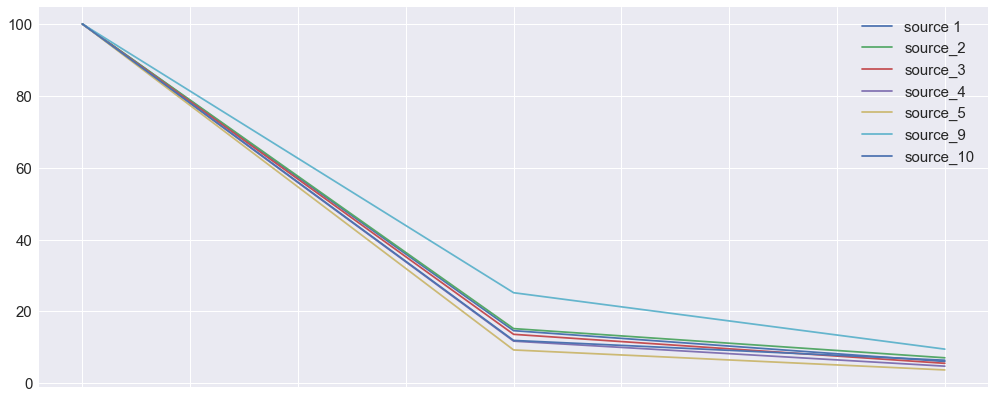

In [53]:
renetion_q4_2016.T.plot();

Видим, что наилучший retention rate у источника 9, а среди наиболее массовых источников (3,4,5) retention лучше у источника 3. Посмотрим на retention q1_2017

In [54]:
q1_2017 = df[
    (df['is_1st_interaction'] == 1) &
    ((df['year_month'] == '2017_1') | (df['year_month'] == '2017_2') | (df['year_month'] == '2017_3'))
]

In [55]:
s1 = q1_2017[q1_2017['source_id'] == 1]['uid']
s2 = q1_2017[q1_2017['source_id'] == 2]['uid']
s3 = q1_2017[q1_2017['source_id'] == 3]['uid']
s4 = q1_2017[q1_2017['source_id'] == 4]['uid']
s5 = q1_2017[q1_2017['source_id'] == 5]['uid']
s9 = q1_2017[q1_2017['source_id'] == 9]['uid']
s10 = q1_2017[q1_2017['source_id'] == 10]['uid']

c2017_q1 = df[(df['year_month'] == '2017_1') | (df['year_month'] == '2017_2') | (df['year_month'] == '2017_3')]['uid'].drop_duplicates()
c2017_q2 = df[(df['year_month'] == '2017_4') | (df['year_month'] == '2017_5')]['uid'].drop_duplicates()

renetion_q1_2017 = pd.DataFrame([
    [
    (s1.isin(c2017_q1).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2017_q2).value_counts()[True] / s1.shape[0] * 100).round(2)],

    [
    (s2.isin(c2017_q1).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2017_q2).value_counts()[True] / s2.shape[0] * 100).round(2)],

    [
    (s3.isin(c2017_q1).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2017_q2).value_counts()[True] / s3.shape[0] * 100).round(2)],

    [
    (s4.isin(c2017_q1).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2017_q2).value_counts()[True] / s4.shape[0] * 100).round(2)],

    [
    (s5.isin(c2017_q1).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2017_q2).value_counts()[True] / s5.shape[0] * 100).round(2)],

    [
    (s9.isin(c2017_q1).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2017_q2).value_counts()[True] / s9.shape[0] * 100).round(2)],

    [
    (s10.isin(c2017_q1).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2017_q2).value_counts()[True] / s10.shape[0] * 100).round(2)]
],
columns=['2017_q1', '2017_q2'],
index=['source 1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_9', 'source_10',]);
renetion_q1_2017

,2017_q1,2017_q2
source 1,100.0,9.10
source_2,100.0,8.00
source_3,100.0,7.07
source_4,100.0,5.75
source_5,100.0,5.05
source_9,100.0,13.03
source_10,100.0,6.18


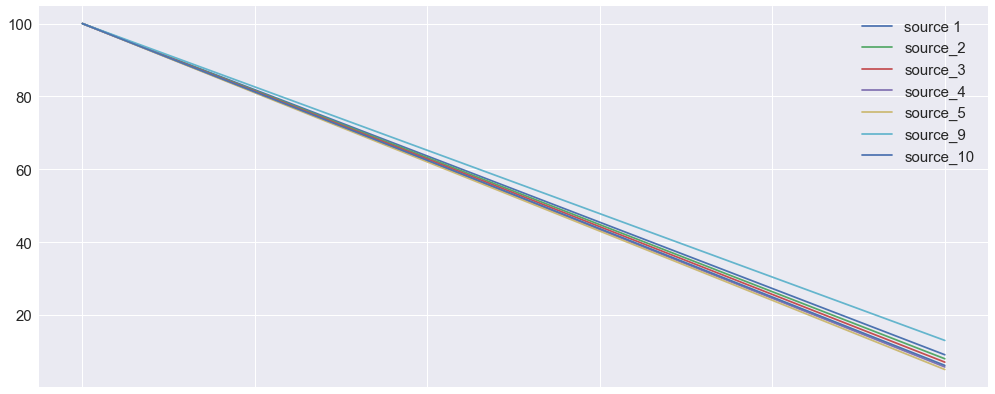

In [56]:
renetion_q1_2017.T.plot();

Наконец, посмотрим на retention помесячно. Возьмем q1 2016, но теперь разобъем когорты на месяцы. С учетом данных выше будет достаточно посмотреть на 1 месяц. Например, октябрь 2016.

In [57]:
m10_2016 = df[
    (df['is_1st_interaction'] == 1) & (df['year_month'] == '2016_10')
]

s1 = m10_2016[m10_2016['source_id'] == 1]['uid']
s2 = m10_2016[m10_2016['source_id'] == 2]['uid']
s3 = m10_2016[m10_2016['source_id'] == 3]['uid']
s4 = m10_2016[m10_2016['source_id'] == 4]['uid']
s5 = m10_2016[m10_2016['source_id'] == 5]['uid']
s9 = m10_2016[m10_2016['source_id'] == 9]['uid']
s10 = m10_2016[m10_2016['source_id'] == 10]['uid']

c2016_10 = df[(df['year_month'] == '2016_10')]['uid'].drop_duplicates()
c2016_11 = df[(df['year_month'] == '2016_11')]['uid'].drop_duplicates()
c2016_12 = df[(df['year_month'] == '2016_12')]['uid'].drop_duplicates()
c2017_1 = df[(df['year_month'] == '2017_1')]['uid'].drop_duplicates()
c2017_2 = df[(df['year_month'] == '2017_2')]['uid'].drop_duplicates()
c2017_3 = df[(df['year_month'] == '2017_3')]['uid'].drop_duplicates()
c2017_4 = df[(df['year_month'] == '2017_4')]['uid'].drop_duplicates()
c2017_5 = df[(df['year_month'] == '2017_5')]['uid'].drop_duplicates()

renetion_m10_2016 = pd.DataFrame([
    [(s1.isin(c2016_10).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2016_11).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2016_12).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2017_1).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2017_2).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2017_3).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2017_4).value_counts()[True] / s1.shape[0] * 100).round(2),
    (s1.isin(c2017_5).value_counts()[True] / s1.shape[0] * 100).round(2)],

    [(s2.isin(c2016_10).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2016_11).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2016_12).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2017_1).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2017_2).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2017_3).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2017_4).value_counts()[True] / s2.shape[0] * 100).round(2),
    (s2.isin(c2017_5).value_counts()[True] / s2.shape[0] * 100).round(2)],

    [(s3.isin(c2016_10).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2016_11).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2016_12).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2017_1).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2017_2).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2017_3).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2017_4).value_counts()[True] / s3.shape[0] * 100).round(2),
    (s3.isin(c2017_5).value_counts()[True] / s3.shape[0] * 100).round(2)],

    [(s4.isin(c2016_10).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2016_11).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2016_12).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2017_1).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2017_2).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2017_3).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2017_4).value_counts()[True] / s4.shape[0] * 100).round(2),
    (s4.isin(c2017_5).value_counts()[True] / s4.shape[0] * 100).round(2)],

    [(s5.isin(c2016_10).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2016_11).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2016_12).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2017_1).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2017_2).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2017_3).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2017_4).value_counts()[True] / s5.shape[0] * 100).round(2),
    (s5.isin(c2017_5).value_counts()[True] / s5.shape[0] * 100).round(2)],

    [(s9.isin(c2016_10).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2016_11).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2016_12).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2017_1).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2017_2).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2017_3).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2017_4).value_counts()[True] / s9.shape[0] * 100).round(2),
    (s9.isin(c2017_5).value_counts()[True] / s9.shape[0] * 100).round(2)],

    [(s10.isin(c2016_10).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2016_11).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2016_12).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2017_1).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2017_2).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2017_3).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2017_4).value_counts()[True] / s10.shape[0] * 100).round(2),
    (s10.isin(c2017_5).value_counts()[True] / s10.shape[0] * 100).round(2)]
],
columns=['2016_10m', '2016_11m', '2016_12m', '2017_1m', '2017_2m', '2017_3m', '2017_4m', '2017_5m'],
index=['source 1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_9', 'source_10',]);
renetion_m10_2016

,2016_10m,2016_11m,2016_12m,2017_1m,2017_2m,2017_3m,2017_4m,2017_5m
source 1,100.0,14.87,9.81,7.04,5.95,4.96,3.87,3.87
source_2,100.0,14.78,8.51,6.79,6.71,6.30,4.69,4.61
source_3,100.0,11.82,7.74,6.14,5.44,4.92,3.34,3.28
source_4,100.0,9.39,6.36,5.11,4.25,4.27,2.91,2.68
source_5,100.0,7.63,4.72,3.69,3.63,3.13,2.15,1.70
source_9,100.0,19.73,14.32,9.24,9.36,11.16,5.30,4.62
source_10,100.0,9.31,5.10,4.35,3.67,4.08,3.60,3.54


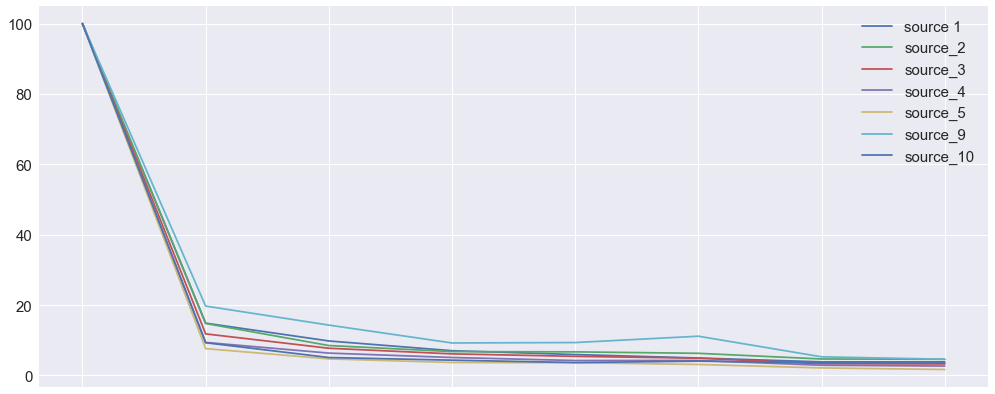

In [58]:
renetion_m10_2016.T.plot();

#### 2. Эффективность каналов с точки зрения покупок пользователей

Как правило, корректная оценка эффективности маркетинговых каналов полностью зависит от атрибуции. Выбор атрибуции, в свою очередь, зависит от особенностей бизнеса. Главным образом, вопрос состоит в том, как корректно распределить доход по источникам в зависимости от вклада каждого источника в конверсию, так как пользователь мог взаимодействовать с разными источниками до конверсии.

Чтобы наглядно продемонстрировать абзац выше, посмотрим, с каким количеством уникальных источников пользователи взаимодействовали. Иными словами, построим таблицу, которая отражает количество уникальных источников на пользователя.

In [59]:
df.groupby('uid')[['source_id']].nunique().reset_index().rename(index=str, columns={'source_id': 'source_id_count'})\
    ['source_id_count'].value_counts(normalize=True) * 100

1    77.801805
2    15.426930
3     4.692453
4     1.531354
5     0.446963
6     0.092076
7     0.008418
Name: source_id_count, dtype: float64

Видим, что только 77% процентов всех пользователей за весь период взаимодействовали только с одним источником. Таким образом, если выбрать атрибуцию последнего перехода, то мы некорректно оценим 33% оставшихся переходов. А они тоже могли внести и, скорее всего, внесли свой вклад в конверсии.

Например, очевидно, что пользователь мог перейти по источнику 1 и зарегистрироваться, а на следующий день перейти по источнику 2 и совершить покупку. Вопрос в том, какую долю от дохода в этом случае отдать источнику 1, а какую - источнику 2.

Здесь на помощь могут прийти воронки. В зависимости от ценности шага воронки мы можем распределить ценность по источникам. Например, 30% - регистрация, 70% - оплата.

Однако для этого недостаточно данных. Мы могли бы распределить ценность от конверсии поровну между всеми источниками, но это тоже некорректный подход (нельзя одинаково оценивать регистрацию и оплату).

Принимая во внимание вышеописанное, возьмем следующие метрики для оценки эффективности источников:
	
**MRR по источникам** (позволит оценить эффективность источников по доходу с точки зрения привлечения платящих пользователей, с поправкой на 77 процентов)<br>

**доля первых визитов, сразу завершившихся конверсией, в общей доле первых визитов по источникам** (позволит оценить, какие источники приводят наиболее расположенных к конверсии пользователей)<br>

**ARPPU по источникам по первому переходу** (позволит оценить ср. чек по первому источнику, опять-таки с поправкой на 77%)<br>

**CR(u)** (позволит оценить, какой процент перешедших пользователей становятся платящими пользователями в разрезе канала привлечения)

**Retention платящих пользователей** (позволит оценить, какой канал лучше привлекает многомесячных плательщиков)

<hr>

Для того, чтобы данные были актуальны, возьмем только 2017 год.

In [60]:
df[df['year'] == 2017].groupby('uid')[['source_id']].nunique().reset_index().rename(index=str, columns={'source_id': 'source_id_count'})\
    ['source_id_count'].value_counts(normalize=True) * 100

1    81.302267
2    13.835543
3     3.606493
4     0.951648
5     0.256233
6     0.045737
7     0.002079
Name: source_id_count, dtype: float64

Видим, что в 2017 году процент, тех, кто пользовался одним источника выше. Это несколько повышает точность оценки. Если же взять в расчет только сессии с конверсиями, то показатель достигает 91.5%

In [61]:
df[(df['year'] == 2017) & (df['is_conversion'] == 1)].groupby('uid')[['source_id']].nunique().reset_index().rename(index=str, columns={'source_id': 'source_id_count'})\
    ['source_id_count'].value_counts(normalize=True) * 100

1    91.672805
2     7.261097
3     0.841248
4     0.166699
5     0.054274
6     0.003877
Name: source_id_count, dtype: float64

In [62]:
df[(df['year'] == 2017) & (df['is_conversion'] == 1)].groupby('source_id')[['revenue_distributed']].agg(['count','sum','median'])

revenue_distributed                   
                        count         sum median
source_id                                       
1                        5140  30772.8508   2.75
2                        4796  34213.3336   2.75
3                        6750  25610.9942   2.44
4                        8138  32443.9668   2.44
5                        7116  30463.6498   2.68
9                         862   2708.5150   1.83
10                       1062   2869.4200   1.83

Найдем сессии тех пользователей, которые пришли в 2017 году.

In [63]:
df_new_users_2017 = df[
    df['year'] == 2017][df[df['year'] == 2017]['uid'].isin(
        df[(df['is_1st_interaction'] == 1) & (df['year'] == 2017)]['uid']
    )
]

In [64]:
df_new_users_2017.groupby('uid')[['source_id']].nunique().reset_index().rename(index=str, columns={'source_id': 'source_id_count'})\
    ['source_id_count'].value_counts(normalize=True) * 100

1    84.570238
2    12.045321
3     2.643318
4     0.595830
5     0.125538
6     0.019118
7     0.000637
Name: source_id_count, dtype: float64

Отмечаем, что 84.5% из них взаимодейстовавали только с одним источником.

### MRR и ARPPU по первому источнику

Рассчитаем доход и ср. чек по первым источникам по новым привлеченным пользователям в 2017 году во общем и ежемесячно

In [65]:
fir_inter['year'] = fir_inter['start_ts'].apply(lambda x: x.year)
fir_inter2017 = fir_inter[fir_inter['year'] == 2017]

In [66]:
gr_overall = df_new_users_2017.groupby('uid')[['revenue_distributed']].sum().reset_index().join(
    fir_inter2017[['uid', 'source_id']].set_index('uid'), on='uid'
).rename(index=str, columns={'source_id':'1st_source_id'})

gr_overall = gr_overall[gr_overall['revenue_distributed'] != 0]

gr_overall = gr_overall.groupby('1st_source_id')[['revenue_distributed']].agg(['sum', 'median'])

In [67]:
gr_overall.columns = gr_overall.columns.map('_'.join)

In [68]:
gr_overall

,revenue_distributed_sum,revenue_distributed_median
1st_source_id,,
1,5558.8900,2.93
2,11251.6802,3.27
3,28066.5601,2.44
4,27928.2200,2.93
5,14270.5500,2.75
9,1149.1700,2.17
10,2823.0600,1.95


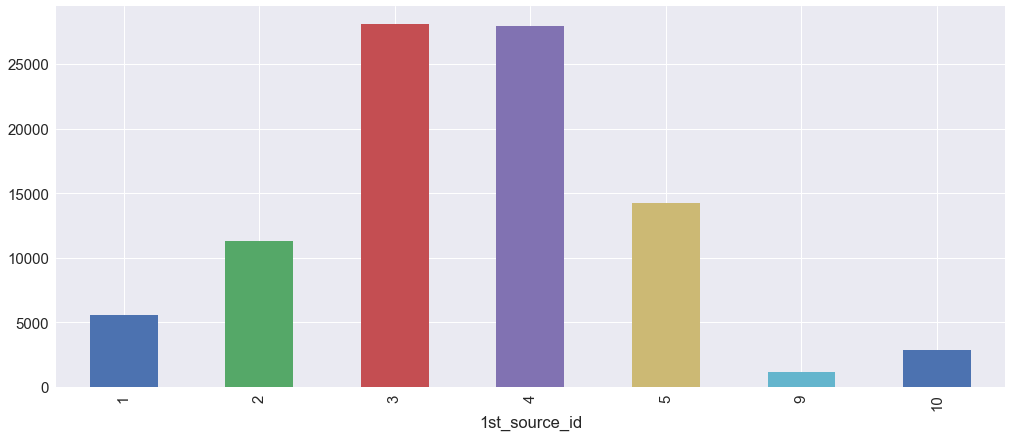

In [69]:
gr_overall['revenue_distributed_sum'].plot(kind='bar');

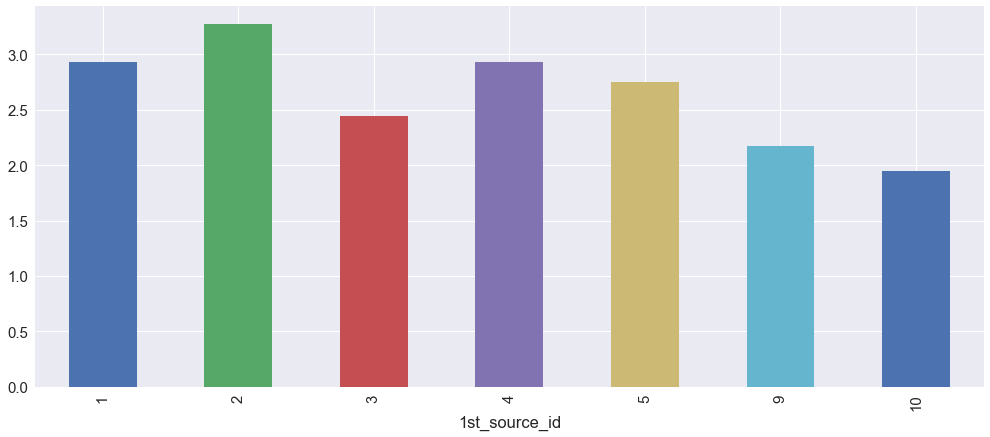

In [70]:
gr_overall['revenue_distributed_median'].plot(kind='bar');

In [71]:
gr_months = df_new_users_2017.groupby(['uid', 'month'])[['revenue_distributed']].sum().reset_index().join(
    fir_inter2017[['uid', 'source_id']].set_index('uid'), on='uid'
).rename(index=str, columns={'source_id':'1st_source_id'})

In [72]:
gr_months = gr_months[gr_months['revenue_distributed'] != 0]

In [73]:
one = gr_months[gr_months['month'] == 1].groupby('1st_source_id')[['revenue_distributed']].agg(['sum', 'median'])
two = gr_months[gr_months['month'] == 2].groupby('1st_source_id')[['revenue_distributed']].agg(['sum', 'median'])
three = gr_months[gr_months['month'] == 3].groupby('1st_source_id')[['revenue_distributed']].agg(['sum', 'median'])
four = gr_months[gr_months['month'] == 4].groupby('1st_source_id')[['revenue_distributed']].agg(['sum', 'median'])
five = gr_months[gr_months['month'] == 5].groupby('1st_source_id')[['revenue_distributed']].agg(['sum', 'median'])

In [74]:
one, two, three, four, five

(              revenue_distributed       
                               sum median
 1st_source_id                           
 1                          667.16   2.44
 2                         1262.12   2.99
 3                         5234.53   2.75
 4                         5140.03   2.57
 5                         2774.46   2.44
 9                          156.92   1.80
 10                         386.93   2.14,
               revenue_distributed       
                               sum median
 1st_source_id                           
 1                       1122.9900   3.05
 2                       1775.2600   2.92
 3                       5762.9801   2.44
 4                       6216.9600   2.75
 5                       3860.7100   3.05
 9                        290.1300   2.50
 10                       461.9000   1.83,
               revenue_distributed       
                               sum median
 1st_source_id                           
 1                         1816.

## доля первых визитов, сразу завершившихся конверсией, в общей доле первых визитов по источникам

In [75]:
cr_sessions = df_new_users_2017[(df_new_users_2017['is_conversion'] == 1) & (df_new_users_2017['is_1st_interaction'] == 1)]\
    .groupby('source_id')[['session_id']].count().rename(index=str, columns={'session_id': 'cr_sessions'})

In [76]:
all_sessions = df_new_users_2017[(df_new_users_2017['is_1st_interaction'] == 1)].groupby('source_id')[['session_id']].count().rename(index=str, columns={'session_id': 'all_sessions'})

In [77]:
result = cr_sessions.join(all_sessions, on='source_id')

In [78]:
result['target'] = (result['cr_sessions'] / result['all_sessions'] * 100).round(2)

In [79]:
result

,cr_sessions,all_sessions,target
source_id,,,
1,730,3848,18.97
2,986,10096,9.77
3,3921,46728,8.39
4,4118,54846,7.51
5,1993,32317,6.17
9,181,2996,6.04
10,600,6073,9.88


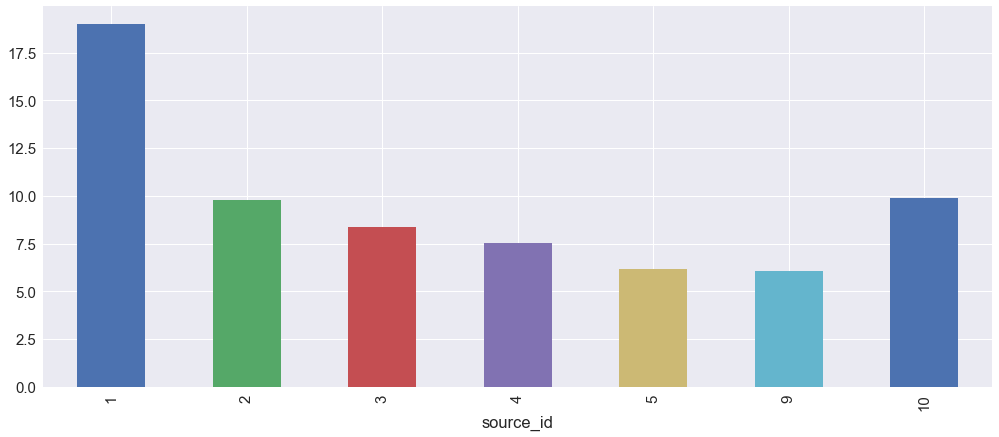

In [80]:
result['target'].plot(kind='bar');

## CR(u)

In [81]:
converters = df_new_users_2017[df_new_users_2017['is_conversion'] == 1].groupby('source_id')[['uid']].nunique()\
    .rename(index=str, columns={'uid': 'converters'})

In [82]:
allusers = df_new_users_2017.groupby('source_id')[['uid']].nunique().rename(index=str, columns={'uid': 'allusers'})

In [83]:
result = converters.join(allusers, on='source_id')

In [84]:
result['target'] = (result['converters'] / result['allusers'] * 100).round(2)

In [85]:
result[['target']]

,target
source_id,
1,24.09
2,14.56
3,9.93
4,9.36
5,10.91
9,8.60
10,12.31


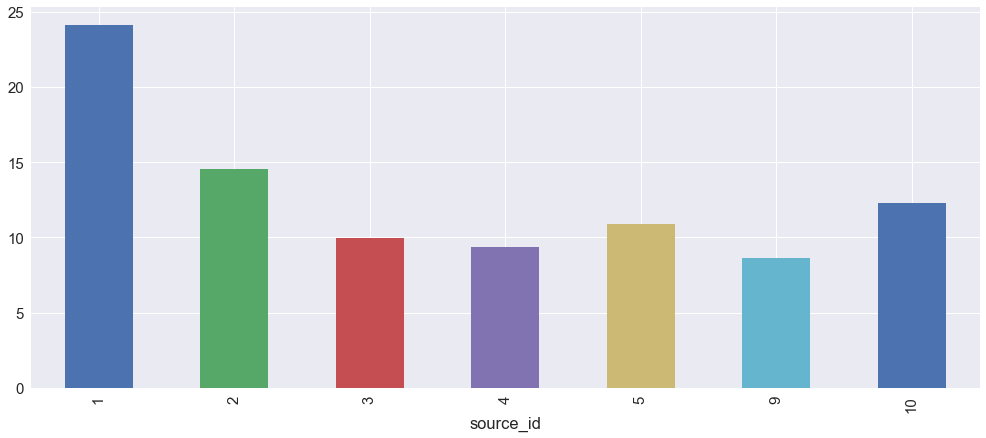

In [86]:
result['target'].plot(kind='bar');

## RETENTION for paying users

Посмотрим на удержание новых платящих пользователей с разбивкой по первому источнику

In [87]:
# когорты новых пользователей

new_2017_1 = df_new_users_2017[
    (df_new_users_2017['is_1st_interaction'] == 1) &
    (df_new_users_2017['year_month'] == '2017_1')
]

new_2017_2 = df_new_users_2017[
    (df_new_users_2017['is_1st_interaction'] == 1) &
    (df_new_users_2017['year_month'] == '2017_2')
]

new_2017_3 = df_new_users_2017[
    (df_new_users_2017['is_1st_interaction'] == 1) &
    (df_new_users_2017['year_month'] == '2017_3')
]

new_2017_4 = df_new_users_2017[
    (df_new_users_2017['is_1st_interaction'] == 1) &
    (df_new_users_2017['year_month'] == '2017_4')
]

new_2017_5 = df_new_users_2017[
    (df_new_users_2017['is_1st_interaction'] == 1) &
    (df_new_users_2017['year_month'] == '2017_5')
]

# когорты платящих пользователей

paying_2017_1 = df_new_users_2017[
    (df_new_users_2017['is_conversion'] == 1) &
    (df_new_users_2017['year_month'] == '2017_1')
]

paying_2017_2 = df_new_users_2017[
    (df_new_users_2017['is_conversion'] == 1) &
    (df_new_users_2017['year_month'] == '2017_2')
]

paying_2017_3 = df_new_users_2017[
    (df_new_users_2017['is_conversion'] == 1) &
    (df_new_users_2017['year_month'] == '2017_3')
]

paying_2017_4 = df_new_users_2017[
    (df_new_users_2017['is_conversion'] == 1) &
    (df_new_users_2017['year_month'] == '2017_4')
]

paying_2017_5 = df_new_users_2017[
    (df_new_users_2017['is_conversion'] == 1) &
    (df_new_users_2017['year_month'] == '2017_5')
]

In [88]:
# когорты новых платящих пользователей

new_2017_1_paying = new_2017_1[new_2017_1['uid'].isin(paying_2017_1['uid'])]
new_2017_2_paying = new_2017_2[new_2017_2['uid'].isin(paying_2017_2['uid'])]
new_2017_3_paying = new_2017_3[new_2017_3['uid'].isin(paying_2017_3['uid'])]
new_2017_4_paying = new_2017_4[new_2017_4['uid'].isin(paying_2017_4['uid'])]

In [89]:
# разобъем когорты новых платящих пользователей по первому источнику перехода

new_2017_1_paying_source1 = new_2017_1_paying[new_2017_1_paying['source_id'] == 1]
new_2017_2_paying_source1 = new_2017_2_paying[new_2017_2_paying['source_id'] == 1]
new_2017_3_paying_source1 = new_2017_3_paying[new_2017_3_paying['source_id'] == 1]
new_2017_4_paying_source1 = new_2017_4_paying[new_2017_4_paying['source_id'] == 1]

new_2017_1_paying_source2 = new_2017_1_paying[new_2017_1_paying['source_id'] == 2]
new_2017_2_paying_source2 = new_2017_2_paying[new_2017_2_paying['source_id'] == 2]
new_2017_3_paying_source2 = new_2017_3_paying[new_2017_3_paying['source_id'] == 2]
new_2017_4_paying_source2 = new_2017_4_paying[new_2017_4_paying['source_id'] == 2]

new_2017_1_paying_source3 = new_2017_1_paying[new_2017_1_paying['source_id'] == 3]
new_2017_2_paying_source3 = new_2017_2_paying[new_2017_2_paying['source_id'] == 3]
new_2017_3_paying_source3 = new_2017_3_paying[new_2017_3_paying['source_id'] == 3]
new_2017_4_paying_source3 = new_2017_4_paying[new_2017_4_paying['source_id'] == 3]

new_2017_1_paying_source4 = new_2017_1_paying[new_2017_1_paying['source_id'] == 4]
new_2017_2_paying_source4 = new_2017_2_paying[new_2017_2_paying['source_id'] == 4]
new_2017_3_paying_source4 = new_2017_3_paying[new_2017_3_paying['source_id'] == 4]
new_2017_4_paying_source4 = new_2017_4_paying[new_2017_4_paying['source_id'] == 4]

new_2017_1_paying_source5 = new_2017_1_paying[new_2017_1_paying['source_id'] == 5]
new_2017_2_paying_source5 = new_2017_2_paying[new_2017_2_paying['source_id'] == 5]
new_2017_3_paying_source5 = new_2017_3_paying[new_2017_3_paying['source_id'] == 5]
new_2017_4_paying_source5 = new_2017_4_paying[new_2017_4_paying['source_id'] == 5]

new_2017_1_paying_source9 = new_2017_1_paying[new_2017_1_paying['source_id'] == 9]
new_2017_2_paying_source9 = new_2017_2_paying[new_2017_2_paying['source_id'] == 9]
new_2017_3_paying_source9 = new_2017_3_paying[new_2017_3_paying['source_id'] == 9]
new_2017_4_paying_source9 = new_2017_4_paying[new_2017_4_paying['source_id'] == 9]

new_2017_1_paying_source10 = new_2017_1_paying[new_2017_1_paying['source_id'] == 10]
new_2017_2_paying_source10 = new_2017_2_paying[new_2017_2_paying['source_id'] == 10]
new_2017_3_paying_source10 = new_2017_3_paying[new_2017_3_paying['source_id'] == 10]
new_2017_4_paying_source10 = new_2017_4_paying[new_2017_4_paying['source_id'] == 10]

Посмотрим на retention по источникам

In [90]:
renetion_2017_source1 = pd.DataFrame([
    [(0 if True not in new_2017_1_paying_source1['uid'].isin(paying_2017_1['uid']).value_counts().index.values else new_2017_1_paying_source1['uid'].isin(paying_2017_1['uid']).value_counts()[True] / new_2017_1_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source1['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_1_paying_source1['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_1_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source1['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_1_paying_source1['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_1_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source1['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_1_paying_source1['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_1_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source1['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_1_paying_source1['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_1_paying_source1['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_2_paying_source1['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_2_paying_source1['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_2_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source1['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_2_paying_source1['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_2_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source1['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_2_paying_source1['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_2_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source1['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_2_paying_source1['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_2_paying_source1['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_3_paying_source1['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_3_paying_source1['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_3_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source1['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_3_paying_source1['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_3_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source1['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_3_paying_source1['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_3_paying_source1['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_4_paying_source1['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_4_paying_source1['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_4_paying_source1['uid'].shape[0] * 100),
    (0 if True not in new_2017_4_paying_source1['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_4_paying_source1['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_4_paying_source1['uid'].shape[0] * 100)]

],
columns=['2017_1', '2017_2', '2017_3', '2017_4', '2017_5',],
index=['2017_1_source1', '2017_2_source1', '2017_3_source1', '2017_4_source1']);
renetion_2017_source1

,2017_1,2017_2,2017_3,2017_4,2017_5
2017_1_source1,100.0,2.247191,1.685393,0.000000,1.123596
2017_2_source1,100.0,2.898551,1.449275,2.415459,NaN
2017_3_source1,100.0,1.025641,1.538462,NaN,NaN
2017_4_source1,100.0,1.960784,NaN,NaN,NaN


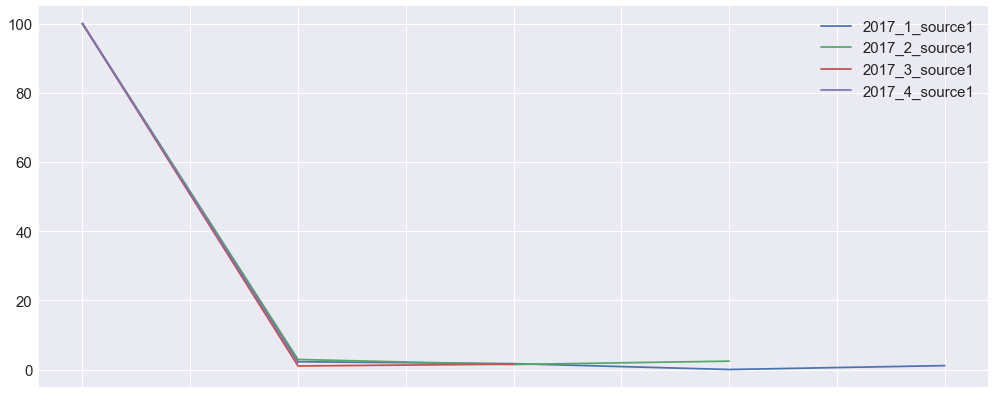

In [91]:
renetion_2017_source1.T.plot();

In [92]:
renetion_2017_source2 = pd.DataFrame([
    [(0 if True not in new_2017_1_paying_source2['uid'].isin(paying_2017_1['uid']).value_counts().index.values else new_2017_1_paying_source2['uid'].isin(paying_2017_1['uid']).value_counts()[True] / new_2017_1_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source2['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_1_paying_source2['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_1_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source2['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_1_paying_source2['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_1_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source2['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_1_paying_source2['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_1_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source2['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_1_paying_source2['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_1_paying_source2['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_2_paying_source2['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_2_paying_source2['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_2_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source2['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_2_paying_source2['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_2_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source2['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_2_paying_source2['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_2_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source2['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_2_paying_source2['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_2_paying_source2['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_3_paying_source2['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_3_paying_source2['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_3_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source2['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_3_paying_source2['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_3_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source2['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_3_paying_source2['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_3_paying_source2['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_4_paying_source2['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_4_paying_source2['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_4_paying_source2['uid'].shape[0] * 100),
    (0 if True not in new_2017_4_paying_source2['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_4_paying_source2['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_4_paying_source2['uid'].shape[0] * 100)]

],
columns=['2017_1', '2017_2', '2017_3', '2017_4', '2017_5',],
index=['2017_1_source2', '2017_2_source2', '2017_3_source2', '2017_4_source2']);
renetion_2017_source2

,2017_1,2017_2,2017_3,2017_4,2017_5
2017_1_source2,100.0,4.838710,4.435484,2.822581,2.419355
2017_2_source2,100.0,4.395604,3.296703,0.732601,NaN
2017_3_source2,100.0,2.536232,1.086957,NaN,NaN
2017_4_source2,100.0,4.188482,NaN,NaN,NaN


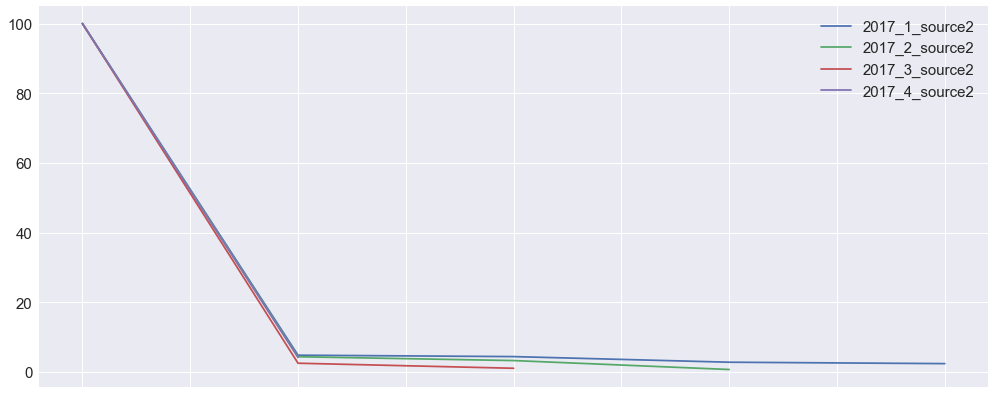

In [93]:
renetion_2017_source2.T.plot();

In [94]:
renetion_2017_source3 = pd.DataFrame([
    [(0 if True not in new_2017_1_paying_source3['uid'].isin(paying_2017_1['uid']).value_counts().index.values else new_2017_1_paying_source3['uid'].isin(paying_2017_1['uid']).value_counts()[True] / new_2017_1_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source3['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_1_paying_source3['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_1_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source3['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_1_paying_source3['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_1_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source3['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_1_paying_source3['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_1_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source3['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_1_paying_source3['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_1_paying_source3['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_2_paying_source3['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_2_paying_source3['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_2_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source3['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_2_paying_source3['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_2_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source3['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_2_paying_source3['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_2_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source3['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_2_paying_source3['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_2_paying_source3['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_3_paying_source3['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_3_paying_source3['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_3_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source3['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_3_paying_source3['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_3_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source3['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_3_paying_source3['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_3_paying_source3['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_4_paying_source3['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_4_paying_source3['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_4_paying_source3['uid'].shape[0] * 100),
    (0 if True not in new_2017_4_paying_source3['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_4_paying_source3['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_4_paying_source3['uid'].shape[0] * 100)]

],
columns=['2017_1', '2017_2', '2017_3', '2017_4', '2017_5',],
index=['2017_1_source3', '2017_2_source3', '2017_3_source3', '2017_4_source3']);
renetion_2017_source3

,2017_1,2017_2,2017_3,2017_4,2017_5
2017_1_source3,100.0,2.852853,1.726727,0.975976,0.3003
2017_2_source3,100.0,2.069950,0.999286,0.927909,NaN
2017_3_source3,100.0,2.392739,1.072607,NaN,NaN
2017_4_source3,100.0,2.206897,NaN,NaN,NaN


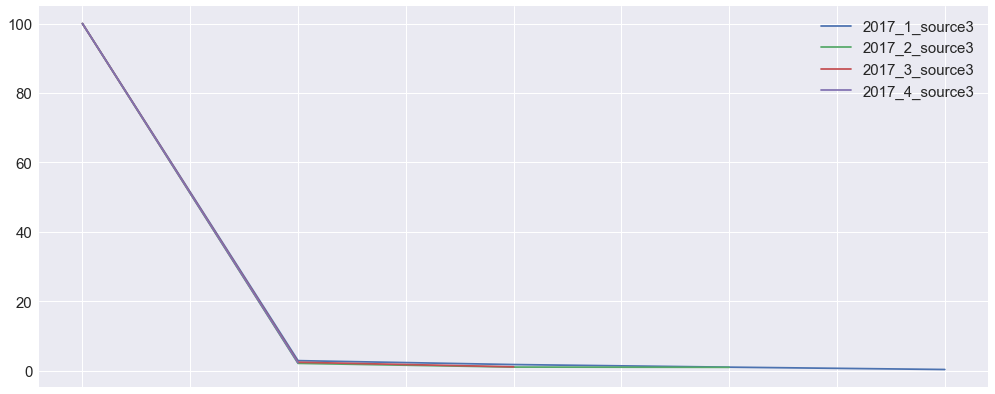

In [95]:
renetion_2017_source3.T.plot()

In [96]:
renetion_2017_source4 = pd.DataFrame([
    [(0 if True not in new_2017_1_paying_source4['uid'].isin(paying_2017_1['uid']).value_counts().index.values else new_2017_1_paying_source4['uid'].isin(paying_2017_1['uid']).value_counts()[True] / new_2017_1_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source4['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_1_paying_source4['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_1_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source4['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_1_paying_source4['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_1_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source4['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_1_paying_source4['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_1_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source4['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_1_paying_source4['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_1_paying_source4['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_2_paying_source4['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_2_paying_source4['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_2_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source4['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_2_paying_source4['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_2_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source4['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_2_paying_source4['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_2_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source4['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_2_paying_source4['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_2_paying_source4['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_3_paying_source4['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_3_paying_source4['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_3_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source4['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_3_paying_source4['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_3_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source4['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_3_paying_source4['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_3_paying_source4['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_4_paying_source4['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_4_paying_source4['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_4_paying_source4['uid'].shape[0] * 100),
    (0 if True not in new_2017_4_paying_source4['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_4_paying_source4['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_4_paying_source4['uid'].shape[0] * 100)]

],
columns=['2017_1', '2017_2', '2017_3', '2017_4', '2017_5',],
index=['2017_1_source4', '2017_2_source4', '2017_3_source4', '2017_4_source4']);
renetion_2017_source4

,2017_1,2017_2,2017_3,2017_4,2017_5
2017_1_source4,100.0,1.909855,1.069519,0.763942,0.458365
2017_2_source4,100.0,2.878229,0.811808,0.516605,NaN
2017_3_source4,100.0,1.402214,1.180812,NaN,NaN
2017_4_source4,100.0,2.338530,NaN,NaN,NaN


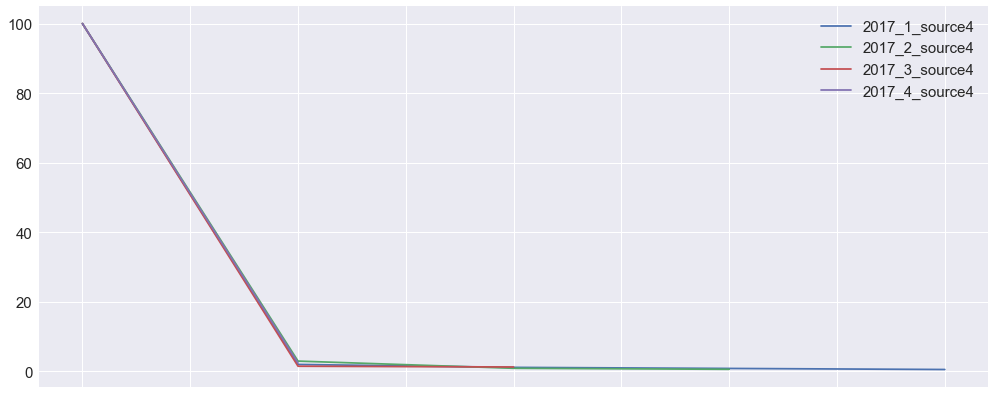

In [97]:
renetion_2017_source4.T.plot();

In [98]:
renetion_2017_source5 = pd.DataFrame([
    [(0 if True not in new_2017_1_paying_source5['uid'].isin(paying_2017_1['uid']).value_counts().index.values else new_2017_1_paying_source5['uid'].isin(paying_2017_1['uid']).value_counts()[True] / new_2017_1_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source5['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_1_paying_source5['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_1_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source5['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_1_paying_source5['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_1_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source5['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_1_paying_source5['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_1_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source5['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_1_paying_source5['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_1_paying_source5['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_2_paying_source5['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_2_paying_source5['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_2_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source5['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_2_paying_source5['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_2_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source5['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_2_paying_source5['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_2_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source5['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_2_paying_source5['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_2_paying_source5['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_3_paying_source5['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_3_paying_source5['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_3_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source5['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_3_paying_source5['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_3_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source5['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_3_paying_source5['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_3_paying_source5['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_4_paying_source5['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_4_paying_source5['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_4_paying_source5['uid'].shape[0] * 100),
    (0 if True not in new_2017_4_paying_source5['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_4_paying_source5['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_4_paying_source5['uid'].shape[0] * 100)]

],
columns=['2017_1', '2017_2', '2017_3', '2017_4', '2017_5',],
index=['2017_1_source5', '2017_2_source5', '2017_3_source5', '2017_4_source5']);
renetion_2017_source5

,2017_1,2017_2,2017_3,2017_4,2017_5
2017_1_source5,100.0,2.832861,2.407932,0.283286,1.133144
2017_2_source5,100.0,2.649007,0.927152,1.192053,NaN
2017_3_source5,100.0,2.680412,0.618557,NaN,NaN
2017_4_source5,100.0,1.508621,NaN,NaN,NaN


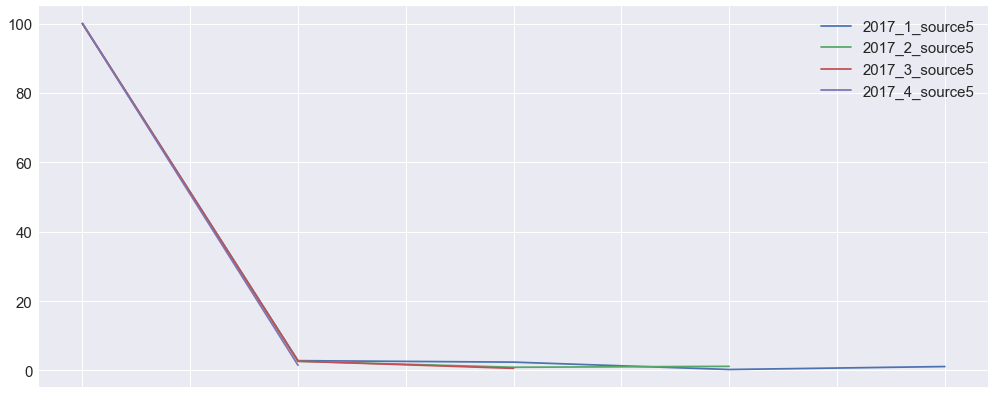

In [99]:
renetion_2017_source5.T.plot()

In [100]:
renetion_2017_source9 = pd.DataFrame([
    [(0 if True not in new_2017_1_paying_source9['uid'].isin(paying_2017_1['uid']).value_counts().index.values else new_2017_1_paying_source9['uid'].isin(paying_2017_1['uid']).value_counts()[True] / new_2017_1_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source9['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_1_paying_source9['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_1_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source9['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_1_paying_source9['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_1_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source9['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_1_paying_source9['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_1_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source9['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_1_paying_source9['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_1_paying_source9['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_2_paying_source9['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_2_paying_source9['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_2_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source9['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_2_paying_source9['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_2_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source9['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_2_paying_source9['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_2_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source9['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_2_paying_source9['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_2_paying_source9['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_3_paying_source9['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_3_paying_source9['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_3_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source9['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_3_paying_source9['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_3_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source9['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_3_paying_source9['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_3_paying_source9['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_4_paying_source9['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_4_paying_source9['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_4_paying_source9['uid'].shape[0] * 100),
    (0 if True not in new_2017_4_paying_source9['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_4_paying_source9['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_4_paying_source9['uid'].shape[0] * 100)]

],
columns=['2017_1', '2017_2', '2017_3', '2017_4', '2017_5',],
index=['2017_1_source9', '2017_2_source9', '2017_3_source9', '2017_4_source9']);
renetion_2017_source9

,2017_1,2017_2,2017_3,2017_4,2017_5
2017_1_source9,100.0,8.695652,4.347826,0.0,0.0
2017_2_source9,100.0,1.785714,1.785714,0.0,NaN
2017_3_source9,100.0,1.754386,0.877193,NaN,NaN
2017_4_source9,100.0,0.000000,NaN,NaN,NaN


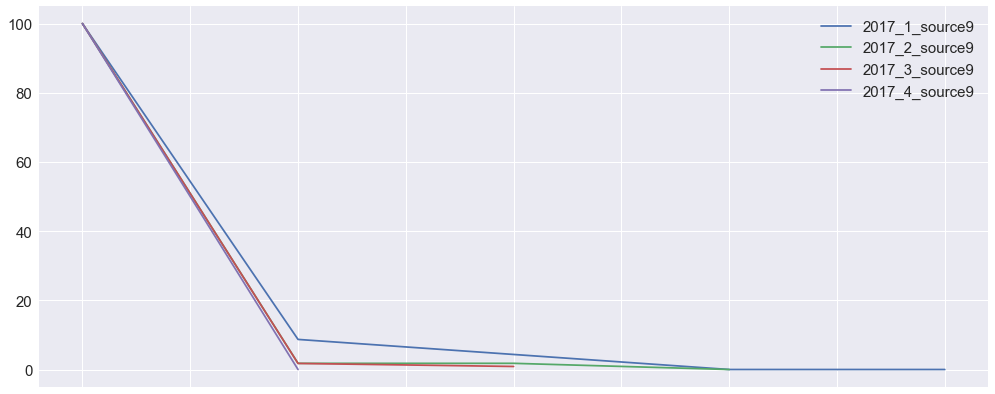

In [101]:
renetion_2017_source9.T.plot();

In [102]:
renetion_2017_source10 = pd.DataFrame([
    [(0 if True not in new_2017_1_paying_source10['uid'].isin(paying_2017_1['uid']).value_counts().index.values else new_2017_1_paying_source10['uid'].isin(paying_2017_1['uid']).value_counts()[True] / new_2017_1_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source10['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_1_paying_source10['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_1_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source10['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_1_paying_source10['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_1_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source10['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_1_paying_source10['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_1_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_1_paying_source10['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_1_paying_source10['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_1_paying_source10['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_2_paying_source10['uid'].isin(paying_2017_2['uid']).value_counts().index.values else new_2017_2_paying_source10['uid'].isin(paying_2017_2['uid']).value_counts()[True] / new_2017_2_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source10['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_2_paying_source10['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_2_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source10['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_2_paying_source10['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_2_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_2_paying_source10['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_2_paying_source10['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_2_paying_source10['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_3_paying_source10['uid'].isin(paying_2017_3['uid']).value_counts().index.values else new_2017_3_paying_source10['uid'].isin(paying_2017_3['uid']).value_counts()[True] / new_2017_3_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source10['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_3_paying_source10['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_3_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_3_paying_source10['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_3_paying_source10['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_3_paying_source10['uid'].shape[0] * 100)],

    [(0 if True not in new_2017_4_paying_source10['uid'].isin(paying_2017_4['uid']).value_counts().index.values else new_2017_4_paying_source10['uid'].isin(paying_2017_4['uid']).value_counts()[True] / new_2017_4_paying_source10['uid'].shape[0] * 100),
    (0 if True not in new_2017_4_paying_source10['uid'].isin(paying_2017_5['uid']).value_counts().index.values else new_2017_4_paying_source10['uid'].isin(paying_2017_5['uid']).value_counts()[True] / new_2017_4_paying_source10['uid'].shape[0] * 100)]

],
columns=['2017_1', '2017_2', '2017_3', '2017_4', '2017_5',],
index=['2017_1_source10', '2017_2_source10', '2017_3_source10', '2017_4_source10']);
renetion_2017_source10

,2017_1,2017_2,2017_3,2017_4,2017_5
2017_1_source10,100.0,1.574803,1.574803,0.0,0.0
2017_2_source10,100.0,1.724138,1.724138,0.0,NaN
2017_3_source10,100.0,2.390438,0.796813,NaN,NaN
2017_4_source10,100.0,0.684932,NaN,NaN,NaN


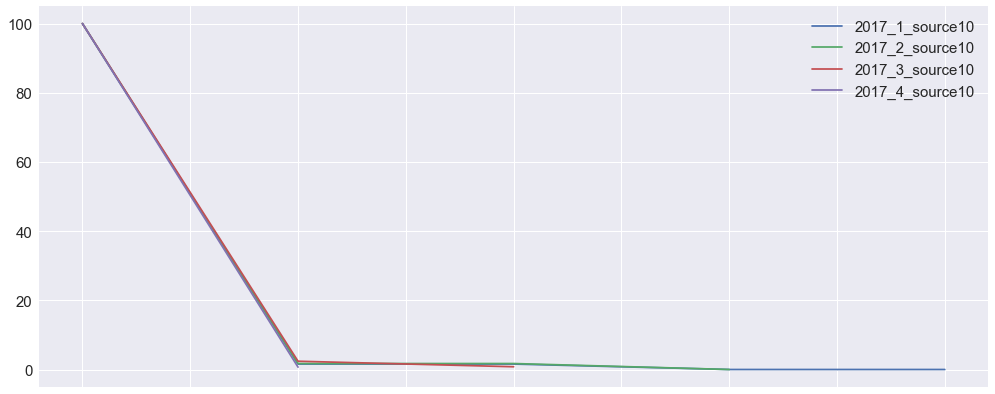

In [103]:
renetion_2017_source10.T.plot();

# RFM

Помимо расчета вышеописанных метрик, возможно разбить пользователей на RFM сегменты, а затем отнести каждого пользователя к первому источника перехода. Таким образом, можно посмотреть какой источник приносит наиболее выгодных с точки зрения RFM-сегментации клиентов.

Для расчетов возьмем только пользователей, пришедших в 2017 году.

In [104]:
df_rfm = df_new_users_2017[df_new_users_2017['is_conversion'] == 1]

В качестве даты снятия отчета возьмем 2017-06-01

In [105]:
now = dt.date(2017,6,1)
print(now)

2017-06-01


### Recency

In [106]:
recency_df = df_rfm.groupby('uid')[['buy_dt']].max().reset_index()
recency_df.columns = ['uid','LastPurshaceDate']

In [107]:
recency_df['LastPurshaceDate'] = pd.to_datetime(recency_df['LastPurshaceDate'])
recency_df['LastPurshaceDate'] = recency_df['LastPurshaceDate'].apply(lambda x: x.date())

In [108]:
#рассчитаем recency
recency_df['recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [109]:
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

In [110]:
recency_df.head()

,uid,recency
0,352142,104
1,510576,123
2,531117,75
3,1506197,65
4,1751328,81


### Frequency

In [111]:
frequency_df = df_rfm.groupby('uid')[['buy_ts']].count().reset_index()
frequency_df.columns = ['uid','frequency']
frequency_df.head()

,uid,frequency
0,352142,1
1,510576,1
2,531117,1
3,1506197,1
4,1751328,1


### Monetary

In [112]:
monetary_df = df_rfm.groupby('uid').agg({'revenue_distributed': 'sum'}).reset_index()
monetary_df.columns = ['uid','monetary']
monetary_df.head()

,uid,monetary
0,352142,1.59
1,510576,1.10
2,531117,1.71
3,1506197,0.92
4,1751328,9.33


Создалим общую таблицу RFM

In [113]:
rfm = recency_df.join(frequency_df.set_index('uid'), on='uid').join(monetary_df.set_index('uid'), on='uid').set_index('uid')

In [114]:
rfm.head()

,recency,frequency,monetary
uid,,,
352142,104,1,1.59
510576,123,1,1.10
531117,75,1,1.71
1506197,65,1,0.92
1751328,81,1,9.33


Классифицируем клиентов в соответствии с их RFM-портретом, используя квантили по каждому показателю

In [115]:
quantiles = rfm.quantile(q=[.25,.5,.75])
quantiles

,recency,frequency,monetary
0.25,39.0,1.0,1.3275
0.50,83.0,1.0,2.7500
0.75,113.0,1.0,4.8900


Отмечаем, что показатель <b>frequency</b> не очень репрезентативен, так как порядка 90% пользователей имели только одну покупку. Уберем его из отчета

In [116]:
(rfm['frequency'].value_counts(normalize=True) * 100).round(2)

1      89.84
2       8.36
3       1.16
4       0.26
5       0.13
6       0.04
11      0.03
8       0.02
12      0.02
9       0.02
22      0.01
34      0.01
18      0.01
16      0.01
7       0.01
10      0.01
17      0.01
50      0.01
33      0.01
193     0.01
46      0.01
82      0.01
19      0.01
29      0.01
38      0.01
23      0.01
24      0.01
26      0.01
42      0.01
85      0.01
Name: frequency, dtype: float64

In [117]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

def MScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [118]:
rfm['r_quantile'] = rfm['recency'].apply(RScore, args=('recency',quantiles,))
rfm['m_quantile'] = rfm['monetary'].apply(MScore, args=('monetary',quantiles,))

In [119]:
rfm.head()

,recency,frequency,monetary,r_quantile,m_quantile
uid,,,,,
352142,104,1,1.59,2,2
510576,123,1,1.10,1,1
531117,75,1,1.71,3,2
1506197,65,1,0.92,3,1
1751328,81,1,9.33,3,4


In [120]:
rfm = rfm.join(fir_inter2017[['uid', 'source_id']].set_index('uid'), on='uid')

In [121]:
monetary_results = rfm[rfm['m_quantile'] == 4].groupby('source_id')[['m_quantile']].count()\
    .rename(index=str, columns={'m_quantile': 'm4'}).join(
rfm[rfm['m_quantile'] == 3].groupby('source_id')[['m_quantile']].count()\
    .rename(index=str, columns={'m_quantile': 'm3'}), on='source_id'
    ).join(
rfm[rfm['m_quantile'] == 2].groupby('source_id')[['m_quantile']].count()\
    .rename(index=str, columns={'m_quantile': 'm2'}), on='source_id'
    ).join(
rfm[rfm['m_quantile'] == 1].groupby('source_id')[['m_quantile']].count()\
    .rename(index=str, columns={'m_quantile': 'm1'}), on='source_id'
    )#.plot(kind='bar', stacked=True);

In [122]:
monetary_results

,m4,m3,m2,m1
source_id,,,,
1,253,243,253,222
2,506,367,377,348
3,1359,1559,1610,1687
4,1588,1697,1635,1458
5,790,817,877,735
9,60,68,103,113
10,154,168,258,351


In [123]:
(monetary_results.apply(lambda r: r/r.sum(), axis=1) * 100).round(2)

,m4,m3,m2,m1
source_id,,,,
1,26.06,25.03,26.06,22.86
2,31.66,22.97,23.59,21.78
3,21.87,25.08,25.91,27.14
4,24.90,26.61,25.63,22.86
5,24.54,25.38,27.24,22.83
9,17.44,19.77,29.94,32.85
10,16.54,18.05,27.71,37.70


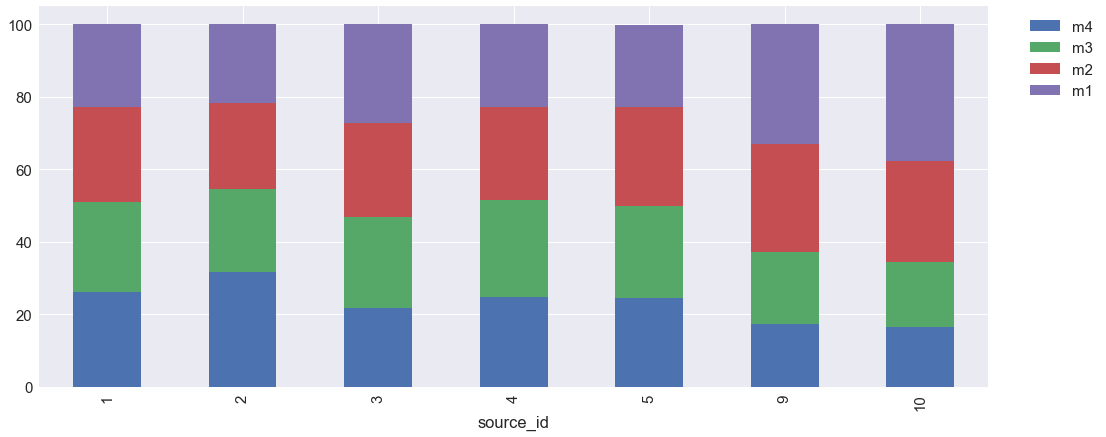

In [124]:
ax = (monetary_results.apply(lambda r: r/r.sum(), axis=1) * 100).round(2).plot(kind='bar', stacked=True);

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset));

In [125]:
recency_results = rfm[rfm['r_quantile'] == 4].groupby('source_id')[['r_quantile']].count()\
    .rename(index=str, columns={'r_quantile': 'r4'}).join(
rfm[rfm['r_quantile'] == 3].groupby('source_id')[['r_quantile']].count()\
    .rename(index=str, columns={'r_quantile': 'r3'}), on='source_id'
    ).join(
rfm[rfm['r_quantile'] == 2].groupby('source_id')[['r_quantile']].count()\
    .rename(index=str, columns={'r_quantile': 'r2'}), on='source_id'
    ).join(
rfm[rfm['r_quantile'] == 1].groupby('source_id')[['r_quantile']].count()\
    .rename(index=str, columns={'r_quantile': 'r1'}), on='source_id'
    )#.plot(kind='bar', stacked=True);

In [126]:
recency_results

,r4,r3,r2,r1
source_id,,,,
1,279,251,202,239
2,608,373,323,294
3,1462,1514,1600,1639
4,1440,1658,1698,1582
5,833,752,751,883
9,72,140,79,53
10,234,315,207,175


In [127]:
(recency_results.apply(lambda r: r/r.sum(), axis=1) * 100).round(2)

,r4,r3,r2,r1
source_id,,,,
1,28.73,25.85,20.80,24.61
2,38.05,23.34,20.21,18.40
3,23.52,24.36,25.74,26.37
4,22.58,26.00,26.62,24.80
5,25.88,23.36,23.33,27.43
9,20.93,40.70,22.97,15.41
10,25.13,33.83,22.23,18.80


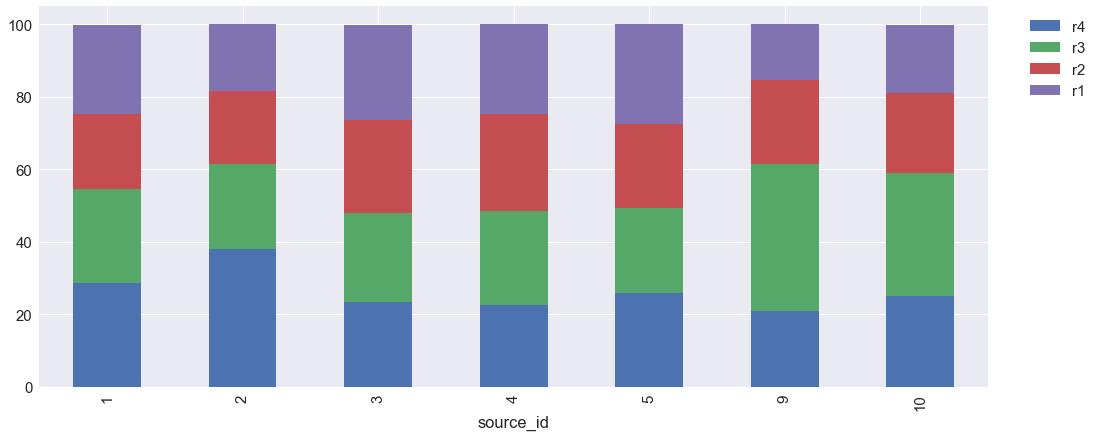

In [128]:
ax = (recency_results.apply(lambda r: r/r.sum(), axis=1) * 100).round(2).plot(kind='bar', stacked=True);

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset));

# ИТОГИ:

Принимая во внимание метрики выше (а также показатели retention rate), возможно, для привлечения пользователей (посещение/оплата) стоит использовать, прежде всего, следующие источники (в порядке убывания значимости) **2, 1, 4, 5**

Причины:
- Ср. чек
- Конверсия в первый платеж при первом же визите
- Пользовательская конверсия
- RFM результаты